In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import roc_curve, auc
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam



In [2]:
data = pd.read_csv('synthetic_iot_dataset.csv')
data.head()

,Device_ID,Temperature,Humidity,Battery_Level,Anomaly
0,Device_1,32.483571,43.248217,43,0
1,Device_2,29.308678,48.554813,70,0
2,Device_3,33.238443,42.075801,29,0
3,Device_4,37.615149,46.920385,91,0
4,Device_5,28.829233,31.063853,40,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Device_ID      2000 non-null   object 
 1   Temperature    2000 non-null   float64
 2   Humidity       2000 non-null   float64
 3   Battery_Level  2000 non-null   int64  
 4   Anomaly        2000 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 78.3+ KB


In [4]:
data.Anomaly.value_counts()

,count
Anomaly,
0,1805
1,195


In [5]:
data.Device_ID.value_counts()

,count
Device_ID,
Device_1984,1
Device_1983,1
Device_1982,1
Device_1981,1
Device_1980,1
...,...
Device_5,1
Device_4,1
Device_3,1


In [6]:
print("Number of duplicates:", data.duplicated().sum())

Number of duplicates: 0


In [7]:
print(data.isnull().sum())

Device_ID        0
Temperature      0
Humidity         0
Battery_Level    0
Anomaly          0
dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder


categorical_columns = ['Device_ID']


label_encoders = {}

for col in categorical_columns:

    data[col] = data[col].fillna(data[col].mode()[0])


    data[col] = data[col].astype(str)


    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

print("Encoding selesai. Encoder tersimpan dalam dictionary 'label_encoders'.")
print(data[categorical_columns].head())

Encoding selesai. Encoder tersimpan dalam dictionary 'label_encoders'.
   Device_ID
0          0
1       1111
2       1223
3       1334
4       1445


In [9]:
from sklearn.model_selection import train_test_split


X = data.drop(columns=['Anomaly'])
y = data['Anomaly']


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)


print(f"Training set   : X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set : X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Test set       : X_test={X_test.shape}, y_test={y_test.shape}")


Training set   : X_train=(1400, 4), y_train=(1400,)
Validation set : X_val=(300, 4), y_val=(300,)
Test set       : X_test=(300, 4), y_test=(300,)


In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


scaler = MinMaxScaler()


X_train_scaled = scaler.fit_transform(X_train)


X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled   = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns)


print("Train min:", X_train_scaled.min().min(), "max:", X_train_scaled.max().max())
print("Val   min:", X_val_scaled.min().min(), "max:", X_val_scaled.max().max())
print("Test  min:", X_test_scaled.min().min(), "max:", X_test_scaled.max().max())


Train min: 0.0 max: 1.0
Val   min: -0.027894997889257978 max: 1.0
Test  min: 0.0 max: 1.0


In [11]:
from imblearn.over_sampling import SMOTE

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Terapkan hanya pada training set (jangan ke val/test!)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Data asli: {X_train_scaled.shape}, Label distribusi: {y_train.value_counts().to_dict()}")
print(f"Data setelah SMOTE: {X_train_resampled.shape}, Label distribusi: {pd.Series(y_train_resampled).value_counts().to_dict()}")


Data asli: (1400, 4), Label distribusi: {0: 1263, 1: 137}
Data setelah SMOTE: (2526, 4), Label distribusi: {0: 1263, 1: 1263}


In [12]:
def create_windows(X, y, window_size=10):
    X_windows = []
    y_windows = []
    for i in range(len(X) - window_size + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size-1])
    return np.array(X_windows), np.array(y_windows)

window_size = 10

X_train_w, y_train_w = create_windows(X_train_scaled, y_train.values, window_size)
X_val_w, y_val_w     = create_windows(X_val_scaled, y_val.values, window_size)
X_test_w, y_test_w   = create_windows(X_test_scaled, y_test.values, window_size)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [16]:
X_train_cnn = X_train_w.reshape((X_train_w.shape[0], X_train_w.shape[1], X_train_w.shape[2], 1))
X_val_cnn   = X_val_w.reshape((X_val_w.shape[0], X_val_w.shape[1], X_val_w.shape[2], 1))
X_test_cnn  = X_test_w.reshape((X_test_w.shape[0], X_test_w.shape[1], X_test_w.shape[2], 1))

print("X_train_cnn shape:", X_train_cnn.shape)


X_train_cnn shape: (1391, 10, 4, 1)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    # CNN mengekstrak fitur per timestep
    TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', padding='same'),
                    input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv1D(128, kernel_size=3, activation='relu', padding='same')),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(GlobalAveragePooling1D()),

    # LSTM untuk ketergantungan waktu
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    # Output binary
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [20]:
history = model.fit(
    X_train_cnn, y_train_w,
    validation_data=(X_val_cnn, y_val_w),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.5855 - loss: 0.6742 - val_accuracy: 0.9003 - val_loss: 0.6655 - learning_rate: 1.0000e-04
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8903 - loss: 0.4776 - val_accuracy: 0.9003 - val_loss: 0.6084 - learning_rate: 1.0000e-04
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8928 - loss: 0.3842 - val_accuracy: 0.9003 - val_loss: 0.5184 - learning_rate: 1.0000e-04
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9078 - loss: 0.3229 - val_accuracy: 0.9003 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9043 - loss: 0.3095 - val_accuracy: 0.9003 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8984 - loss: 0.3036 - val_accuracy: 0.9003 - val_loss: 0.3011 - learning_rate: 1.0000e-04
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.900

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Akurasi test: 0.993127147766323
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       262
           1       1.00      0.93      0.96        29

    accuracy                           0.99       291
   macro avg       1.00      0.97      0.98       291
weighted avg       0.99      0.99      0.99       291



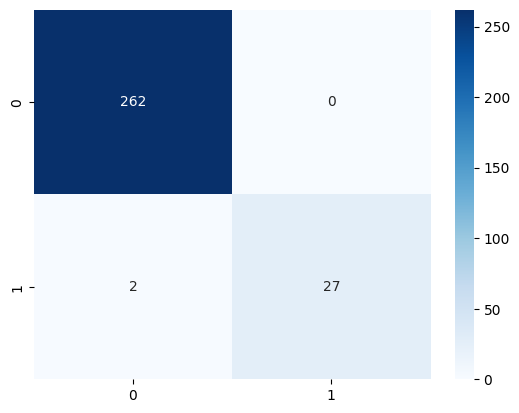

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test_w, y_pred)
print("Akurasi test:", accuracy)
print(classification_report(y_test_w, y_pred))

cm = confusion_matrix(y_test_w, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


ROC-AUC: 1.0


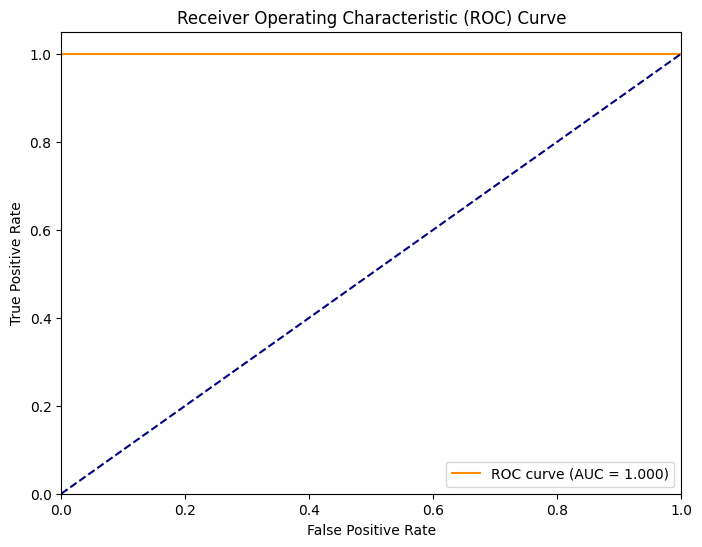

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

# Hitung ROC-AUC
roc_auc = roc_auc_score(y_test_w, y_pred_prob)
print("ROC-AUC:", roc_auc)

# Hitung false positive rate (fpr) dan true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(y_test_w, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # garis random
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
